# 1 Set up and get DATA

In [2]:
#Import

import matplotlib.pyplot as plt
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data', 'images')
numb_images = 30

In [4]:
cap = cv2.VideoCapture(1)
for imgnum in range(numb_images):
    print("Cellecting image : {}".format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.png')
    cv2.imwrite(imgname, frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

2024-05-02 19:24:33.304 Python[77452:3850985] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Cellecting image : 0
Cellecting image : 1
Cellecting image : 2
Cellecting image : 3
Cellecting image : 4
Cellecting image : 5
Cellecting image : 6
Cellecting image : 7
Cellecting image : 8
Cellecting image : 9
Cellecting image : 10
Cellecting image : 11
Cellecting image : 12
Cellecting image : 13
Cellecting image : 14
Cellecting image : 15
Cellecting image : 16
Cellecting image : 17
Cellecting image : 18
Cellecting image : 19
Cellecting image : 20
Cellecting image : 21
Cellecting image : 22
Cellecting image : 23
Cellecting image : 24
Cellecting image : 25
Cellecting image : 26
Cellecting image : 27
Cellecting image : 28
Cellecting image : 29


# 2. Review dataset ad build image loading Function

In [4]:
import tensorflow as tf
import json
import numpy as np

In [5]:
# Limit GPU Memory Growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_logical_devices('GPU')

[]

In [42]:
# Load images

images = tf.data.Dataset.list_files('data/train/images/*.png', shuffle=False)

In [9]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_png(byte_img)
    return img

In [44]:
images = images.map(load_image)

In [61]:
images.as_numpy_iterator().next().shape

(1080, 1920, 3)

In [46]:
image_generator = images.batch(4).as_numpy_iterator()

In [62]:
plot_images = image_generator.next()

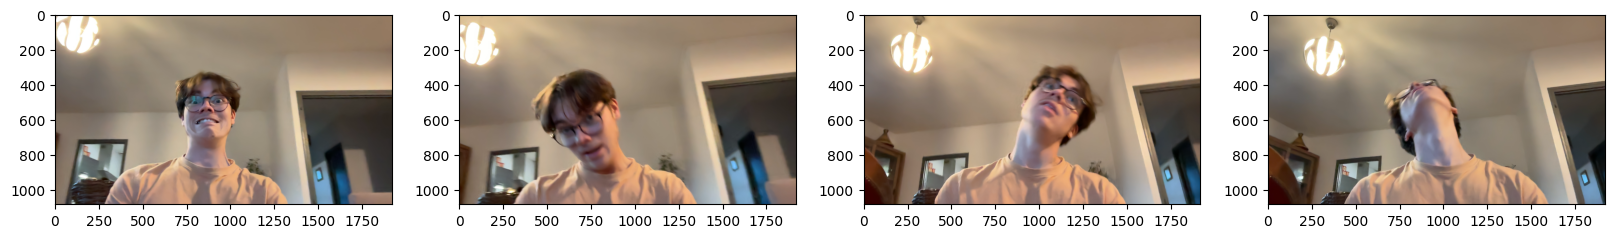

In [63]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
# Move the matching labels

for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on images and labels using Albumentations

In [7]:
import albumentations as alb

In [142]:
augmentor = alb.Compose([alb.RandomCrop(1080, 1920),
                            alb.HorizontalFlip(p=0.5),
                            alb.RandomBrightnessContrast(p=0.2),
                            alb.RandomGamma(p=0.2),
                            alb.RGBShift(p=0.2),
                            alb.VerticalFlip(p=0.5)],
                            bbox_params=alb.BboxParams(format='albumentations',
                                                        label_fields=['class_labels']))


In [143]:
# Example
img = cv2.imread(os.path.join('data', 'train', 'images','00c3a280-04c9-11ef-b311-fa6804503739.png'))

In [144]:
img.shape

(1080, 1920, 3)

In [145]:
with open(os.path.join('data', 'train', 'labels', '00c3a280-04c9-11ef-b311-fa6804503739.json')) as f:
    label = json.load(f)

In [150]:
label["shapes"][0]["points"]

[[787.3333333333334, 366.0], [1282.0, 986.0]]

In [130]:
# Extract coordinates

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [131]:
coords = list(np.divide(coords, [1920, 1080, 1920, 1080]))

In [132]:
coords

[0.4100694444444445, 0.3388888888888889, 0.6677083333333333, 0.912962962962963]

In [133]:
# Augmentation and result

augmented = augmentor(image=img,bboxes=[coords], class_labels=['face'])

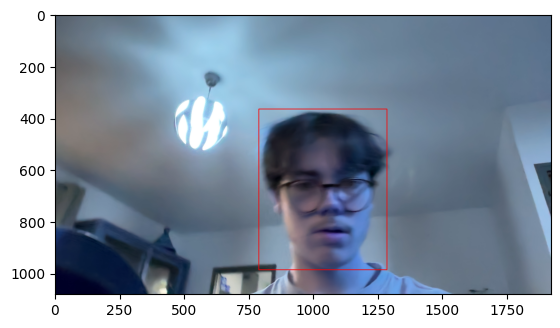

In [134]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [1920,1080]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1920,1080]).astype(int)),
                (255,0,0), 2)
plt.imshow(augmented['image'])

## 5. Augmentation for all

In [157]:
for partition in ['test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            print(label['shapes'])
            print(image)
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

[{'label': 'face', 'points': [[586.0, 386.0], [1066.0, 838.0]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}, 'mask': None}]
a0af79dc-04c8-11ef-b311-fa6804503739.png
[{'label': 'face', 'points': [[771.3333333333334, 226.0], [1194.0, 740.6666666666666]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}, 'mask': None}]
f99eea32-04c8-11ef-b311-fa6804503739.png
[{'label': 'face', 'points': [[248.66666666666666, 74.0], [786.0, 623.3333333333334]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}, 'mask': None}]
fc1d41e6-04c8-11ef-b311-fa6804503739.png
[{'label': 'face', 'points': [[1834.0, 455.33333333333337], [1244.6666666666665, 3.3333333333333286]], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}, 'mask': None}]
a49e7ade-04c8-11ef-b311-fa6804503739.png
x_max is less than or equal to x_min for bbox [0.9552083333333333, 0.421604938271605, 0.6482638888888889, 0.003086419753086415

In [34]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (360, 640)))
train_images = train_images.map(lambda x: x/255.0)

In [33]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (360, 640)))
test_images = test_images.map(lambda x: x/255.0)

In [35]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (360, 640)))
val_images = val_images.map(lambda x: x/255.0)

## 6. Prepare Labels

In [36]:
def load_labels(label_path):
    with open(label_path.numpy().decode('utf-8')) as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [37]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.201 , 0.2537, 0.4656, 0.7686], dtype=float16))

## 7. Combine Labels and Images

In [41]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3120, 3120, 600, 600, 660, 660)

In [42]:
# Final dataset

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [43]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [44]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [45]:
data_sample = train.as_numpy_iterator()

In [64]:
res = data_sample.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


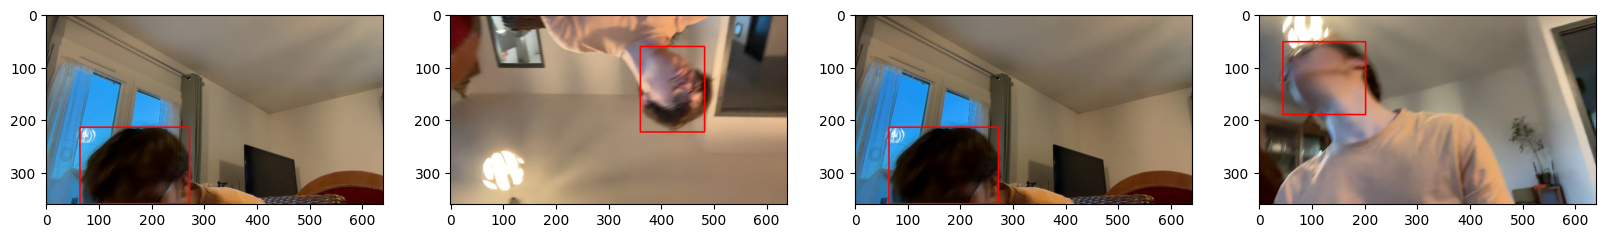

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [640, 360]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [640, 360]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. DEEP MODEL

In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [73]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [74]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
def build_model():
    input_layer = Input(shape=(360, 640, 3))

    vgg = VGG16(include_top=False)(input_layer)

    #Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    #Regression Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [76]:
facetracker = build_model()

In [77]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 360, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 11, 20,    │ 14,714,688 │ input_layer_1[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
X, y = train.as_numpy_iterator().next()

In [82]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [84]:
classes

array([[0.3504312 ],
       [0.3821188 ],
       [0.24329124],
       [0.37412456],
       [0.39035589],
       [0.29747024],
       [0.29601333],
       [0.27707192]], dtype=float32)

## 9. Loss and Optimizer

In [86]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [87]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:32: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [88]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [89]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [97]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.447096>

In [102]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0127764>

In [103]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.447096>

# 10 Train

In [174]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            print(y[0])
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [175]:
model = FaceTracker(facetracker)

In [176]:
model.compile(opt, classloss, regressloss)

In [177]:
# Training
logdir = 'logs'

In [178]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [179]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/40
Tensor("data_1:0", dtype=uint8)


TypeError: Loss.__call__() missing 1 required positional argument: 'y_pred'